This code produces Figure 9 in the manuscript: compariosn of nonlinear solutions with the steady Green's function solution. 

The code requires FEniCSx---see the README for details.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../nonlinear-model')

In [2]:
from main import solve
from params import H, Nx, Nz, rho_w, rho_i
from smb import smb_h, smb_s
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import numpy as np
from params import t_r,t_f,nt,L
from scipy.interpolate import griddata,interp1d

In [3]:
m0 = 5 / 3.154e7                # max basal melt(+) or freeze(-) rate (m/yr)
stdev = 10*H/3                  # standard deviation for Gaussian basal melt anomaly

Solve problem with small melt rate:

In [4]:
a = lambda x,t: smb_h(x,t,0.2*m0,stdev)
m = lambda x,t: smb_s(x,t,0.2*m0,stdev)

h,s,u,w,x,x_vel,z_vel = solve(a,m)

Solve the problem with a larger melt rate:

In [5]:
a2 = lambda x,t: smb_h(x,t,m0,stdev)
m2 = lambda x,t: smb_s(x,t,m0,stdev)

h2,s2,u2,w2,x,x_vel,z_vel = solve(a2,m2)

Interpolate velocity solution for plotting:

In [6]:
 ex = 1 # vertical exaggeration factor for plotting, default = 1 is no exaggeration

def interp_vel(h,s,u,w,x,x_vel,z_vel,ex):
    z_g = z_vel/H
    x_g = x_vel/H
    x0 = x/H

    he = h[:,-1]/H-1
    se = s[:,-1]/H

    h_int = interp1d(x0,he)
    s_int = interp1d(x0,se)

    z_d = (1-z_g)*ex*s_int(x_g) + z_g*(ex*h_int(x_g)+1)

    points = (x_g,z_d)
    nxi = 101
    nzi = 101
    xi = np.linspace(x_g.min(),x_g.max(),num=nxi)
    zi = np.linspace(z_d.min()+0.01,z_d.max(),num=nzi)

    Xi,Zi = np.meshgrid(xi,zi)
    points_i = (Xi,Zi)
    Uc = griddata(points=points,values=u, xi=points_i,fill_value=0)
    Wc = griddata(points=points,values=w, xi=points_i,fill_value=0)
    speed = np.sqrt(Uc**2 + Wc**2)
    return Uc, Wc, speed, xi, zi

Uc,Wc,speed, xi, zi = interp_vel(h,s,u,w,x,x_vel,z_vel,ex)
Uc2,Wc2,speed2, xi2, zi2 = interp_vel(h2,s2,u2,w2,x,x_vel,z_vel,ex)

Compute linear steady solution for verification via Green's function:

In [7]:
# Green's function for steady, linearized problem:
G = (1./4)*np.pi*(1/np.cosh((np.pi*(x/H))/2.)**2) *(-3+np.pi*(x/H)*np.tanh((np.pi*x/H)/2.0))

# scaled basal melt rate:
M = m(x,0)*t_r/H
M2 = m2(x,0)*t_r/H  
# compute convolution solution:
h0 = convolve(G,M,mode='same')*(x[1]-x[0])/H
h0_2 = convolve(G,M2,mode='same')*(x[1]-x[0])/H 

Plot everything:

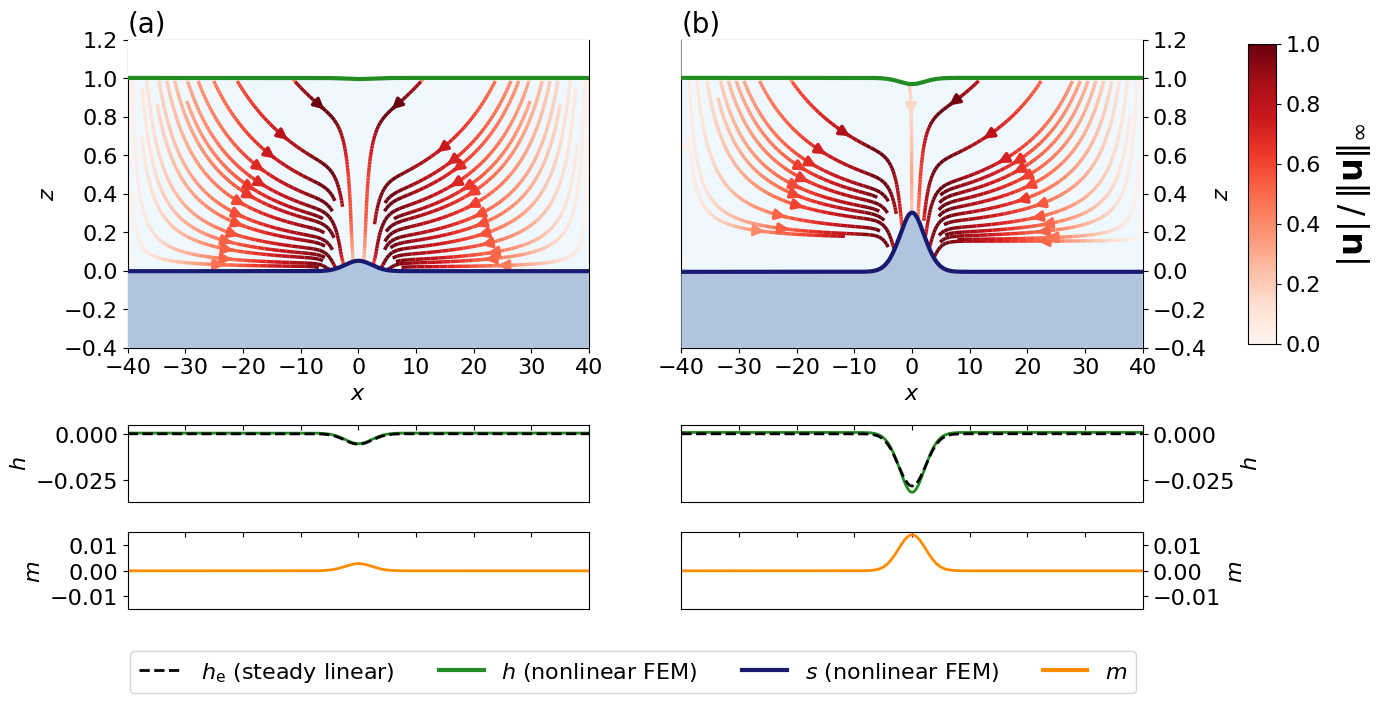

In [8]:
t = np.linspace(0,t_f, nt)
M_max = (t_r/H)*np.abs(m(0,t)).max()
delta = rho_w/rho_i - 1

i = -1
plt.close()
fig = plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title(r'(a)',fontsize=20,loc='left',zorder=100)
plt.plot(x/H,10+ex*h0,linewidth=2,color='k',linestyle='--',label=r'$h_\mathrm{e}$ (steady linear)',zorder=41)
plt.plot(x/H,1+ex*(h[:,i]-H)/H,linewidth=3,color='forestgreen',label=r'$h$ (nonlinear FEM)',zorder=31)
plt.plot(x/H,ex*s[:,i]/H,linewidth=3,color='midnightblue',label=r'$s$ (nonlinear FEM)',zorder=32)
plt.plot(x/H,10+ex*s[:,i]/H,linewidth=3,color='darkorange',label=r'$m$',zorder=32)
plt.fill_between(x/H,y1=ex*s[:,i]/H, y2=1+ex*(h[:,i]-H)/H,facecolor='aliceblue',alpha=1.0)
plt.fill_between(x/H,y1=-2*np.ones(np.size(x)), y2=ex*s[:,i]/H,facecolor='lightsteelblue',alpha=1,zorder=15)
stream = plt.streamplot(xi,zi,Uc/speed.max(),Wc/speed.max(),color=speed/speed.max(),arrowsize=1.5,linewidth=2.5,minlength=0.7,density=2,cmap='Reds')
plt.fill_between(x/H,y1=1+ex*(h[:,i]-H)/H,y2=2*np.ones(x.size),facecolor='w',alpha=1.0,zorder=16)

plt.ylabel(r'$z$',fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16,ncol=4,bbox_to_anchor=(2.21,-0.95))
plt.ylim(-0.4,1.2)
plt.xlim(-0.5*L/H,0.5*L/H)

axins = plt.gca().inset_axes([0.0, -0.85, 1.0, 0.25],sharex=plt.gca())
axins.plot(x/H,m(x,t[i])*t_r/H,linewidth=2,color='darkorange',linestyle='-')
axins.set_ylabel(r'$m$',fontsize=16,color='k')
axins.set_ylim(-np.abs(M2).max()-1e-3,np.abs(M2).max()+1e-3)
axins.tick_params(axis='y', which='major', labelsize=16,color='k',labelcolor='k')
axins.tick_params(axis='x',direction="in",which='major', labelsize=16,top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(axins.get_xticklabels(), visible=False)

axins = plt.gca().inset_axes([0.0, -0.5,1, 0.25],sharex=plt.gca())
axins.plot(x/H,(h[:,i]-H)/H,linewidth=2,color='forestgreen',linestyle='-')
axins.plot(x/H,h0,linewidth=2,color='k',linestyle='--')
axins.set_ylabel(r'$h$',fontsize=16,color='k')
axins.set_ylim(-np.abs((h2[:,i]-H)/H).max()-0.005,0.005)
axins.tick_params(axis='y', which='major', labelsize=16,color='k',labelcolor='k')
axins.tick_params(axis='x',direction="in",which='major', labelsize=16,top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(axins.get_xticklabels(), visible=False)

plt.subplot(122)
plt.title(r'(b)',fontsize=20,loc='left',zorder=100)
plt.plot(x/H,10+ex*h0_2,linewidth=2,color='k',linestyle='--',zorder=41)
plt.plot(x/H,1+ex*(h2[:,i]-H)/H,linewidth=3,color='forestgreen',zorder=31)
plt.plot(x/H,ex*s2[:,i]/H,linewidth=3,color='midnightblue',zorder=32)
plt.fill_between(x/H,y1=ex*s2[:,i]/H, y2=1+ex*(h2[:,i]-H)/H,facecolor='aliceblue',alpha=1.0)
plt.fill_between(x/H,y1=-2*np.ones(np.size(x)), y2=ex*s2[:,i]/H,facecolor='lightsteelblue',alpha=1,zorder=15)
stream = plt.streamplot(xi2,zi2,Uc2/speed2.max(),Wc2/speed2.max(),color=speed2/speed2.max(),arrowsize=1.5,linewidth=2.5,minlength=0.7,density=2,cmap='Reds')
plt.fill_between(x/H,y1=1+ex*(h2[:,i]-H)/H,y2=2*np.ones(x.size),facecolor='w',alpha=1.0,zorder=16)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

plt.ylabel(r'$z$',fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(-0.4,1.2)
plt.xlim(-0.5*L/H,0.5*L/H)

axins = plt.gca().inset_axes([0.0, -0.85, 1.0, 0.25],sharex=plt.gca())
axins.plot(x/H,m2(x,t[i])*t_r/H,linewidth=2,color='darkorange',linestyle='-')
axins.set_ylabel(r'$m$',fontsize=16,color='k')
axins.yaxis.set_label_position("right")
axins.set_ylim(-np.abs(M2).max()-1e-3,np.abs(M2).max()+1e-3)
axins.tick_params(axis='y', which='major', labelsize=16,color='k',labelcolor='k',left=False, labelleft=False, right=True, labelright=True)
axins.tick_params(axis='x',direction="in",which='major', labelsize=16,top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(axins.get_xticklabels(), visible=False)
axins.yaxis.set_offset_position('right')

axins = plt.gca().inset_axes([0.0, -0.5,1, 0.25],sharex=plt.gca())
axins.plot(x/H,(h2[:,i]-H)/H,linewidth=2,color='forestgreen')
axins.plot(x/H,h0_2,linewidth=2,color='k',linestyle='--')
axins.set_ylabel(r'$h$',fontsize=16,color='k')
axins.yaxis.set_label_position("right")
axins.set_ylim(-np.abs((h2[:,i]-H)/H).max()-0.005,0.005)
axins.yaxis.set_offset_position('right')
axins.tick_params(axis='y', which='major', labelsize=16,color='k',labelcolor='k',left=False, labelleft=False, right=True, labelright=True)
axins.tick_params(axis='x',direction="in",which='major', labelsize=16,top=True, labeltop=True, bottom=False, labelbottom=False)
plt.setp(axins.get_xticklabels(), visible=False)


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.925, 0.12, 0.02, 0.75])
cbar = fig.colorbar(stream.lines,cax=cbar_ax,orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$|\mathbf{u}|\,/\, \Vert\mathbf{u}\Vert_\infty$',fontsize=24,labelpad=10)
cbar.ax.tick_params(labelsize=16)

plt.savefig('fig11',bbox_inches='tight')
plt.show()
plt.close()